<a href="https://colab.research.google.com/github/brijmal/BAI4U-V2/blob/main/enzyme_trained_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 40.5 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import requests
from tqdm import tqdm
import json
from Bio import SeqIO
from io import StringIO
import urllib.parse
import re

class EnzymeDataCollector:
    def __init__(self, uniprot_api="https://rest.uniprot.org/uniprotkb/"):
        self.uniprot_api = uniprot_api

    def fetch_enzyme_data(self, enzyme_class=None, enzyme_name=None, max_entries=500):
        """
        Fetch enzyme sequences and metadata from UniProt

        Args:
            enzyme_class: EC number or enzyme class (e.g., "3.4.21" for serine proteases)
            enzyme_name: Common name of enzyme (e.g., "lipase", "protease")
            max_entries: Maximum number of entries to retrieve (max 500 per UniProt API limit)

        Returns:
            DataFrame with enzyme data
        """
        # Ensure we don't exceed the API limit
        if max_entries > 500:
            print("Warning: UniProt API limits results to 500 per request. Setting max_entries to 500.")
            max_entries = 500

        # Build query based on input
        if enzyme_class:
            # Try a more general query format for EC numbers
            query = f'ec:{enzyme_class.split(".")[0]}* AND reviewed:true'
        elif enzyme_name:
            query = f'{enzyme_name} AND reviewed:true'  # Simplified query
        else:
            raise ValueError("Either enzyme_class or enzyme_name must be provided")

        print(f"Searching UniProt for: {query}")

        # Properly URL encode the query parameter
        encoded_query = urllib.parse.quote(query)
        url = f"{self.uniprot_api}search?query={encoded_query}&format=json&size={max_entries}"

        print(f"API URL: {url}")  # Print the full URL for debugging

        response = requests.get(url)
        print(f"Response status code: {response.status_code}")

        try:
            data = response.json()

            if 'results' not in data or len(data['results']) == 0:
                print(f"No results found for query: {query}")
                # Try a more general query as fallback
                if enzyme_class and '.' in enzyme_class:
                    print("Trying more general EC query...")
                    return self.fetch_enzyme_data(enzyme_class=enzyme_class.split(".")[0])
                elif enzyme_name and ' ' in enzyme_name:
                    print("Trying more general enzyme name query...")
                    return self.fetch_enzyme_data(enzyme_name=enzyme_name.split()[0])
                return pd.DataFrame()

            print(f"Found {len(data['results'])} entries")

            enzymes = []
            for entry in data['results']:
                # Extract relevant information
                enzyme = {
                    'id': entry['primaryAccession'],
                    'name': entry.get('proteinDescription', {}).get('recommendedName', {}).get('fullName', {}).get('value', ''),
                    'sequence': entry.get('sequence', {}).get('value', ''),
                    'length': entry.get('sequence', {}).get('length', 0),
                    'organism': entry.get('organism', {}).get('scientificName', '')
                }

                # Extract EC numbers
                ec_numbers = []
                for protein in entry.get('proteinDescription', {}).get('recommendedName', {}).get('ecNumbers', []):
                    if 'value' in protein:
                        ec_numbers.append(protein['value'])
                enzyme['ec_numbers'] = ';'.join(ec_numbers) if ec_numbers else ''

                enzymes.append(enzyme)

            return pd.DataFrame(enzymes)
        except Exception as e:
            print(f"Error fetching enzyme data: {e}")
            return pd.DataFrame()

    def download_pdb(self, pdb_id, output_dir):
        """
        Download PDB file for a given PDB ID

        Args:
            pdb_id: PDB identifier
            output_dir: Directory to save the PDB file
        """
        url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
        response = requests.get(url)

        if response.status_code == 200:
            output_path = os.path.join(output_dir, f"{pdb_id}.pdb")
            with open(output_path, 'w') as f:
                f.write(response.text)
            print(f"Downloaded {pdb_id} to {output_path}")
            return output_path
        else:
            print(f"Failed to download PDB file for {pdb_id}: {response.status_code}")
            return None

    def fetch_structures_for_dataset(self, enzyme_df, output_dir="enzyme_structures"):
        """
        Fetch available 3D structures for enzymes in the dataset

        Args:
            enzyme_df: DataFrame with enzyme data (must contain 'id' column with UniProt IDs)
            output_dir: Directory to save PDB files

        Returns:
            Dictionary mapping UniProt IDs to PDB IDs
        """
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

        structures_map = {}

        # Use tqdm for progress bar if available
        for i, row in enumerate(enzyme_df.iterrows()):
            i, row = row  # Unpack the tuple
            uniprot_id = row['id']

            # Get structure data from PDBe
            url = f"https://www.ebi.ac.uk/pdbe/api/mappings/best_structures/{uniprot_id}"
            response = requests.get(url)

            if response.status_code == 200:
                try:
                    structure_data = response.json()

                    # Check if the response contains data for this UniProt ID
                    if uniprot_id in structure_data:
                        # Check if the data is in the expected format
                        if isinstance(structure_data[uniprot_id], dict):
                            best_structures = structure_data[uniprot_id].get('PDB', [])
                        else:
                            # Handle case where the response is a list or other format
                            print(f"Unexpected data format for {uniprot_id}")
                            best_structures = []

                        structures_map[uniprot_id] = best_structures

                        # Download the first available structure
                        if best_structures:
                            pdb_id = best_structures[0]['pdb_id']
                            self.download_pdb(pdb_id, output_dir)
                    else:
                        print(f"No structure data found for {uniprot_id}")
                        structures_map[uniprot_id] = []
                except Exception as e:
                    print(f"Error processing structure data for {uniprot_id}: {e}")
                    structures_map[uniprot_id] = []
            else:
                print(f"Failed to fetch structure data for {uniprot_id}: {response.status_code}")
                structures_map[uniprot_id] = []

        return structures_map

    def save_dataset(self, enzyme_df, output_file="enzyme_dataset.csv", search_term="enzyme"):
        """
        Save enzyme dataset to CSV file

        Args:
            enzyme_df: DataFrame with enzyme data
            output_file: Output file name or path
            search_term: The search term used (enzyme name or EC number) for naming the file

        Returns:
            Path to the saved file
        """
        # Clean the search term for filename (remove special characters)
        clean_term = re.sub(r'[^\w\s]', '_', search_term)
        clean_term = clean_term.replace(' ', '_')

        # Create filename based on the search term
        filename = f"{clean_term}_dataset.csv"

        # Save to file
        enzyme_df.to_csv(filename, index=False)
        print(f"Saved dataset with {len(enzyme_df)} entries to {filename}")

        # Check if running in Google Colab
        try:
            import google.colab
            is_colab = True
            print("Running in Google Colab environment")
        except:
            is_colab = False

        # If in Colab, offer to save to Google Drive
        if is_colab:
            save_to_drive = input("Save dataset to Google Drive? (y/n): ").lower()
            if save_to_drive == 'y':
                try:
                    from google.colab import drive
                    drive.mount('/content/drive')

                    drive_path = input("Enter Google Drive path (e.g., 'MyDrive/enzyme_data/'): ")
                    if not drive_path.endswith('/'):
                        drive_path += '/'

                    full_path = f"/content/drive/{drive_path}{filename}"

                    # Create directory if it doesn't exist
                    os.makedirs(f"/content/drive/{drive_path}", exist_ok=True)

                    # Save to Google Drive
                    enzyme_df.to_csv(full_path, index=False)
                    print(f"Dataset saved to Google Drive at: {full_path}")

                    # Return the Google Drive path for future reference
                    return full_path
                except Exception as e:
                    print(f"Error saving to Google Drive: {e}")
                    print("Falling back to local save")
                    return filename

        return filename

def main():
    # Initialize data collector
    collector = EnzymeDataCollector()

    # Get user input for enzyme class or name
    print("Enter enzyme class (EC number) or enzyme name to search:")
    print("Examples: '3.4.21' for serine proteases, 'lipase' for lipases")

    search_type = input("Search by EC number (e) or enzyme name (n)? ").lower()

    # Ask user how many entries they want to fetch
    try:
        max_entries = int(input("How many entries to fetch (max 500)? "))
        max_entries = min(500, max(1, max_entries))  # Ensure between 1 and 500
    except ValueError:
        print("Invalid number. Defaulting to 100 entries.")
        max_entries = 100

    search_term = ""
    if search_type == 'e':
        ec_number = input("Enter EC number (e.g., 3.4.21): ")
        search_term = ec_number
        enzyme_data = collector.fetch_enzyme_data(enzyme_class=ec_number, max_entries=max_entries)
    elif search_type == 'n':
        enzyme_name = input("Enter enzyme name (e.g., lipase): ")
        search_term = enzyme_name
        enzyme_data = collector.fetch_enzyme_data(enzyme_name=enzyme_name, max_entries=max_entries)
    else:
        print("Invalid option. Defaulting to lipases.")
        search_term = "lipase"
        enzyme_data = collector.fetch_enzyme_data(enzyme_name="lipase", max_entries=max_entries)

    if not enzyme_data.empty:
        # Save dataset with search term in filename
        output_file = collector.save_dataset(enzyme_data, search_term=search_term)

        # Ask if user wants to fetch structures
        fetch_structures = input("Fetch 3D structures for enzymes? (y/n): ").lower()

        if fetch_structures == 'y':
            # Ask how many structures to fetch
            try:
                num_structures = int(input("How many structures to fetch (max 10 recommended)? "))
                num_structures = min(num_structures, len(enzyme_data))
            except ValueError:
                print("Invalid number. Defaulting to 5.")
                num_structures = min(5, len(enzyme_data))

            # Create a structures directory named after the enzyme/EC number
            structures_dir = f"{search_term}_structures"

            # Fetch structures for a subset of enzymes
            sample_df = enzyme_data.sample(num_structures)
            print(f"Fetching structures for {len(sample_df)} enzymes...")
            structures = collector.fetch_structures_for_dataset(sample_df, structures_dir)

            print(f"Found structures for {sum(1 for v in structures.values() if v)} enzymes")

            # If in Colab, provide instructions for accessing in VAE model
            try:
                import google.colab
                print("\nTo access this data in vae_model.py in Google Colab:")
                print("1. Upload vae_model.py to Colab")
                print("2. Add this code at the beginning of the notebook:")
                print("```python")
                print("# Mount Google Drive")
                print("from google.colab import drive")
                print("drive.mount('/content/drive')")
                print("")
                print("# Load the dataset")
                print(f"import pandas as pd")
                print(f"enzyme_data = pd.read_csv('/content/drive/MyDrive/path/to/{search_term}_dataset.csv')")
                print("```")
            except:
                # Not in Colab, provide regular instructions
                print(f"\nTo use this data with vae_model.py, load it with:")
                print("```python")
                print(f"import pandas as pd")
                print(f"enzyme_data = pd.read_csv('{search_term}_dataset.csv')")
                print("```")
    else:
        print("No enzyme data found")

if __name__ == "__main__":
    main()

Enter enzyme class (EC number) or enzyme name to search:
Examples: '3.4.21' for serine proteases, 'lipase' for lipases
Search by EC number (e) or enzyme name (n)? n
How many entries to fetch (max 500)? 15
Enter enzyme name (e.g., lipase): PETase
Searching UniProt for: PETase AND reviewed:true
API URL: https://rest.uniprot.org/uniprotkb/search?query=PETase%20AND%20reviewed%3Atrue&format=json&size=15
Response status code: 200
Found 11 entries
Saved dataset with 11 entries to PETase_dataset.csv
Running in Google Colab environment
Save dataset to Google Drive? (y/n): y
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Enter Google Drive path (e.g., 'MyDrive/enzyme_data/'): MyDrive/enzyme_data/
Dataset saved to Google Drive at: /content/drive/MyDrive/enzyme_data/PETase_dataset.csv
Fetch 3D structures for enzymes? (y/n): n


In [ ]:
pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 25.7 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted

Please enter the filename of the enzyme dataset:
Example: lactase_dataset.csv
Filename: PETase_dataset.csv

Please enter the path in Google Drive where the file is stored:
Example: MyDrive/enzyme_data
Drive path: MyDrive/enzyme_data
Looking for data at: /content/drive/MyDrive/enzyme_data/PETase_dataset.csv
Loading data from Google Drive: /content/drive/MyDrive/enzyme_data/PETase_dataset.csv
Loaded dataset with 11 enzyme sequences
Maximum sequence length: 603
Training VAE model for PETase with 11 sequences...


Epoch 1/50: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Epoch 1/50, Loss: 3.0722


Epoch 2/50: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 2/50, Loss: 6327.7451


Epoch 3/50: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 3/50, Loss: 119.2296


Epoch 4/50: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Epoch 4/50, Loss: 698.5497


Epoch 5/50: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 5/50, Loss: 101.7112


Epoch 6/50: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch 6/50, Loss: 383.0996


Epoch 7/50: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch 7/50, Loss: 491.6046


Epoch 8/50: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch 8/50, Loss: 241.0626


Epoch 9/50: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch 9/50, Loss: 257.5764


Epoch 10/50: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch 10/50, Loss: 316.1234


Epoch 11/50: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Epoch 11/50, Loss: 171.1972


Epoch 12/50: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Epoch 12/50, Loss: 250.9491


Epoch 13/50: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Epoch 13/50, Loss: 163.5187


Epoch 14/50: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Epoch 14/50, Loss: 146.0776


Epoch 15/50: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Epoch 15/50, Loss: 234.9482


Epoch 16/50: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch 16/50, Loss: 128.7073


Epoch 17/50: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Epoch 17/50, Loss: 179.7584


Epoch 18/50: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Epoch 18/50, Loss: 99.2534


Epoch 19/50: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Epoch 19/50, Loss: 119.1560


Epoch 20/50: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 20/50, Loss: 115.6280


Epoch 21/50: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch 21/50, Loss: 106.9669


Epoch 22/50: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch 22/50, Loss: 75.5915


Epoch 23/50: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch 23/50, Loss: 67.1730


Epoch 24/50: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch 24/50, Loss: 95.9228


Epoch 25/50: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch 25/50, Loss: 91.8744


Epoch 26/50: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch 26/50, Loss: 72.9962


Epoch 27/50: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch 27/50, Loss: 46.0579


Epoch 28/50: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Epoch 28/50, Loss: 40.4568


Epoch 29/50: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Epoch 29/50, Loss: 46.8750


Epoch 30/50: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Epoch 30/50, Loss: 46.3811


Epoch 31/50: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Epoch 31/50, Loss: 37.3867


Epoch 32/50: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Epoch 32/50, Loss: 23.7272


Epoch 33/50: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch 33/50, Loss: 18.7875


Epoch 34/50: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch 34/50, Loss: 21.5432


Epoch 35/50: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch 35/50, Loss: 25.4100


Epoch 36/50: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 36/50, Loss: 21.1482


Epoch 37/50: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch 37/50, Loss: 18.3265


Epoch 38/50: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch 38/50, Loss: 14.9128


Epoch 39/50: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 39/50, Loss: 14.3693


Epoch 40/50: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch 40/50, Loss: 16.1248


Epoch 41/50: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch 41/50, Loss: 14.4486


Epoch 42/50: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch 42/50, Loss: 11.6703


Epoch 43/50: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch 43/50, Loss: 8.4914


Epoch 44/50: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch 44/50, Loss: 8.6790


Epoch 45/50: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch 45/50, Loss: 9.6738


Epoch 46/50: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch 46/50, Loss: 9.5733


Epoch 47/50: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Epoch 47/50, Loss: 7.5671


Epoch 48/50: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Epoch 48/50, Loss: 7.0838


Epoch 49/50: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Epoch 49/50, Loss: 6.7416


Epoch 50/50: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Epoch 50/50, Loss: 6.0986
Also saved plot to Google Drive: /content/drive/MyDrive/enzyme_models/PETase_training_metrics_20250303_090721.png


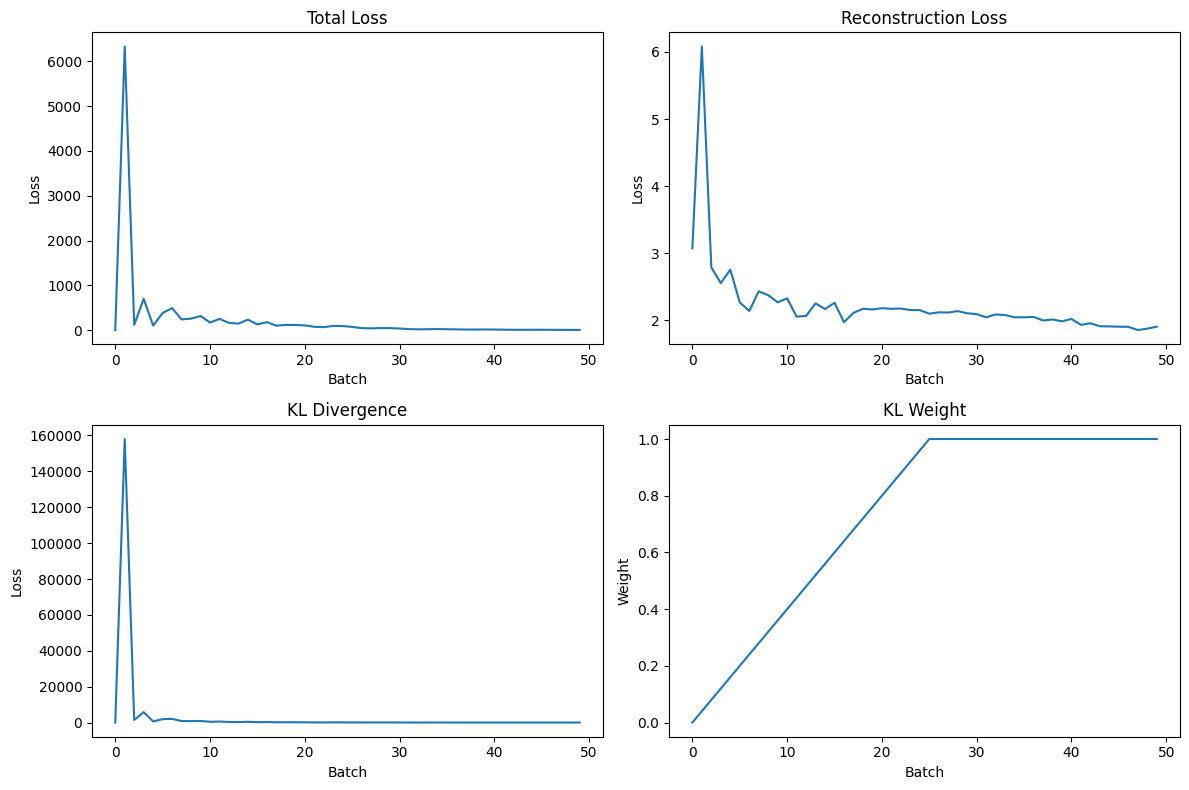

Model saved to PETase_vae_model_20250303_090721.pt
Also saved model to Google Drive: /content/drive/MyDrive/enzyme_models/PETase_vae_model_20250303_090721.pt

Generating 10 new PETase sequences...

Template-guided generation produces more biologically plausible sequences.
Would you like to provide a template sequence for this enzyme class? (y/n): y

Enter '1' to paste a sequence, '2' to provide a UniProt ID, or '3' to search UniProt: 2
Enter UniProt ID/accession (e.g., P0DTC2): A0A0K8P6T7
Retrieved template from UniProt (290 amino acids)
Saved 10 generated sequences to PETase_generated/PETase_generated_20250303_091711.fasta
Also saved sequences to Google Drive: /content/drive/MyDrive/enzyme_models/generated/PETase_generated_20250303_091711.fasta

Sample of generated sequences:
Sequence 1: PHFLFNDDNFFSPWMASDTRQCPFWTKEQVEHNPVACTSWFMPFAVGNGV...
Sequence 2: CANTEKRDAAGSNSAGVLPLNNTADMNPAVATWMALAPACYEVRIKANIS...
Sequence 3: TRTALNAWFACDWTSGVIPWWRFQIRIQVTMANRRADDGALNMNANMESS...
Sequence 4: SR

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import os
import argparse
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys

# Google Colab integration utility functions
def check_if_colab():
    """Check if running in Google Colab"""
    try:
        import google.colab
        return True
    except:
        return False

def mount_google_drive():
    """Mount Google Drive if in Colab environment"""
    if check_if_colab():
        from google.colab import drive
        drive.mount('/content/drive')
        print("Google Drive mounted")
        return True
    else:
        print("Not running in Colab, skipping drive mount")
        return False

def load_enzyme_data(file_path, is_colab=False, drive_path=None):
    """
    Load enzyme data from CSV file in local filesystem or Google Drive

    Args:
        file_path: Path to CSV file (local path if not in Colab)
        is_colab: Whether running in Colab
        drive_path: Google Drive path if in Colab (e.g., 'MyDrive/enzyme_data')

    Returns:
        DataFrame with enzyme data
    """
    if is_colab and drive_path:
        # Format the full path for Colab
        if not drive_path.endswith('/'):
            drive_path += '/'
        full_path = f"/content/drive/{drive_path}{file_path}"
        print(f"Looking for data at: {full_path}")

        # Check if the directory exists
        drive_dir = f"/content/drive/{drive_path}"
        if not os.path.exists(drive_dir):
            print(f"Warning: Directory {drive_dir} does not exist!")
            print("Available directories in /content/drive:")
            for d in os.listdir("/content/drive"):
                print(f"  - {d}")

            # Try to find files in other locations
            print("\nLooking for CSV files in common locations...")
            possible_locations = [
                "/content/drive/MyDrive",
                "/content/drive/MyDrive/datasets",
                "/content/drive/Shareddrives",
                "/content"
            ]

            found_files = []
            for loc in possible_locations:
                if os.path.exists(loc):
                    for root, _, files in os.walk(loc, topdown=True, followlinks=False):
                        # Don't go too deep to avoid slow search
                        if root.count('/') > loc.count('/') + 2:
                            continue
                        for file in files:
                            if file.endswith('.csv') and file_path.lower() in file.lower():
                                found_files.append(os.path.join(root, file))
                                if len(found_files) >= 5:  # Limit to 5 matches
                                    break

            if found_files:
                print("\nFound potentially matching files:")
                for i, found_file in enumerate(found_files):
                    print(f"{i+1}: {found_file}")

                choice = input("\nEnter the number of the correct file, or 'n' to enter a new path: ")
                if choice.isdigit() and 1 <= int(choice) <= len(found_files):
                    return pd.read_csv(found_files[int(choice)-1])
                else:
                    new_path = input("Enter the complete path to the file: ")
                    if os.path.exists(new_path):
                        return pd.read_csv(new_path)
                    else:
                        raise FileNotFoundError(f"File not found: {new_path}")
            else:
                print("No matching CSV files found.")
                new_path = input("Enter the complete path to the file: ")
                if os.path.exists(new_path):
                    return pd.read_csv(new_path)
                else:
                    raise FileNotFoundError(f"File not found: {new_path}")

        # If directory exists, list available CSV files
        elif not os.path.exists(full_path):
            print(f"File {file_path} not found in {drive_dir}")

            csv_files = [f for f in os.listdir(drive_dir) if f.endswith('.csv')]
            if csv_files:
                print("\nAvailable CSV files in this directory:")
                for i, csv_file in enumerate(csv_files):
                    print(f"{i+1}: {csv_file}")

                choice = input("\nEnter the number of the file to use, or 'n' to enter a new filename: ")
                if choice.isdigit() and 1 <= int(choice) <= len(csv_files):
                    selected_file = csv_files[int(choice)-1]
                    return pd.read_csv(f"{drive_dir}{selected_file}")
                else:
                    new_filename = input("Enter the filename: ")
                    new_path = f"{drive_dir}{new_filename}"
                    if os.path.exists(new_path):
                        return pd.read_csv(new_path)
                    else:
                        raise FileNotFoundError(f"File not found: {new_path}")
            else:
                print("No CSV files found in this directory.")
                new_path = input("Enter the complete path to the file: ")
                if os.path.exists(new_path):
                    return pd.read_csv(new_path)
                else:
                    raise FileNotFoundError(f"File not found: {new_path}")

        else:
            print(f"Loading data from Google Drive: {full_path}")
            return pd.read_csv(full_path)
    else:
        print(f"Loading data from local path: {file_path}")
        return pd.read_csv(file_path)

class EnzymeVAE(nn.Module):
    def __init__(self, seq_length, embedding_dim, latent_dim, kl_anneal_cycles=1):
        super(EnzymeVAE, self).__init__()

        # Save parameters
        self.seq_length = seq_length
        self.embedding_dim = embedding_dim
        self.latent_dim = latent_dim

        # Encoder
        self.embedding = nn.Embedding(21, embedding_dim)  # 20 amino acids + padding
        self.encoder = nn.Sequential(
            nn.Conv1d(embedding_dim, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, padding=1)
        )

        # Latent space
        self.fc_mu = nn.Linear(256 * seq_length, latent_dim)
        self.fc_var = nn.Linear(256 * seq_length, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * seq_length)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 21, kernel_size=3, padding=1)  # 20 amino acids + padding
        )

        # KL annealing parameters
        self.kl_anneal_cycles = kl_anneal_cycles
        self.current_step = 0
        self.total_steps = 0

    def encode(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)  # Change to channels-first
        x = self.encoder(x)
        x = x.flatten(1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 256, self.seq_length)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

    def get_kl_weight(self):
        """
        Calculate KL annealing weight using cyclical schedule
        """
        if self.total_steps == 0:
            return 0.0

        # Cyclical annealing
        cycle_length = self.total_steps // self.kl_anneal_cycles
        cycle_position = self.current_step % cycle_length
        kl_weight = min(1.0, cycle_position / (cycle_length * 0.5))

        return kl_weight

    def loss_function(self, recon_x, x, mu, log_var):
        """
        Calculate VAE loss with KL annealing
        """
        # Reconstruction loss (cross entropy for categorical data)
        # Reshape to handle the correct dimensions
        batch_size = x.size(0)
        recon_x = recon_x.view(batch_size, 21, -1)  # [batch, 21, seq_length]

        # Use cross entropy on the correct dimensions
        recon_loss = F.cross_entropy(recon_x, x.long())

        # KL divergence
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Apply KL annealing weight
        kl_weight = self.get_kl_weight()

        # Update step counter
        self.current_step += 1

        return recon_loss + kl_weight * kl_div, recon_loss, kl_div, kl_weight

    def set_total_steps(self, total_steps):
        """
        Set the total number of training steps for KL annealing
        """
        self.total_steps = total_steps
        self.current_step = 0

    def generate_sequences(self, num_sequences=10, enzyme_name="enzyme", save_dir=None, temperature=0.8):
        """
        Generate new enzyme sequences from the latent space

        Args:
            num_sequences: Number of sequences to generate
            enzyme_name: Name of enzyme for output file
            save_dir: Directory to save generated sequences
            temperature: Controls randomness (lower = more conservative, higher = more diverse)

        Returns:
            List of generated sequences
        """
        # Define amino acid vocabulary - must match the same ordering used during training
        amino_acids = "ACDEFGHIKLMNPQRSTVWY"
        aa_list = list(amino_acids)  # Only include the 20 standard amino acids

        # Create directory if it doesn't exist
        if save_dir and not os.path.exists(save_dir):
            os.makedirs(save_dir)

        self.eval()  # Set to evaluation mode
        sequences = []
        attempts = 0
        max_attempts = num_sequences * 5  # Allow multiple attempts per desired sequence

        # First try to get template from user
        print("\nTemplate-guided generation produces more biologically plausible sequences.")
        template_choice = input("Would you like to provide a template sequence for this enzyme class? (y/n): ")

        template = None
        if template_choice.lower() == 'y':
            template_source = input("\nEnter '1' to paste a sequence, '2' to provide a UniProt ID, or '3' to search UniProt: ")

            if template_source == '1':
                template = input("Paste your template sequence (amino acids only): ")
                template = ''.join(c for c in template if c.isalpha())  # Clean up the sequence
                print(f"Template accepted ({len(template)} amino acids)")

            elif template_source == '2':
                uniprot_id = input("Enter UniProt ID/accession (e.g., P0DTC2): ")
                try:
                    import requests
                    response = requests.get(f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta")
                    if response.status_code == 200:
                        fasta_text = response.text
                        # Parse the FASTA format to extract the sequence
                        lines = fasta_text.strip().split('\n')
                        if len(lines) > 1:
                            template = ''.join(lines[1:])
                            print(f"Retrieved template from UniProt ({len(template)} amino acids)")
                        else:
                            print("Error parsing UniProt response")
                            template = None
                    else:
                        print(f"Error retrieving UniProt entry: {response.status_code}")
                        template = None
                except Exception as e:
                    print(f"Error accessing UniProt: {e}")
                    template = None

            elif template_source == '3':
                search_term = input(f"Enter search terms for {enzyme_name} (e.g., 'PETase IsPETase polyester hydrolase'): ")
                if not search_term:
                    search_term = enzyme_name

                try:
                    import requests
                    url = f"https://rest.uniprot.org/uniprotkb/search?query={search_term}%20AND%20reviewed:true&format=json&size=5"
                    print(f"Searching UniProt: {url}")

                    response = requests.get(url)
                    if response.status_code == 200:
                        data = response.json()
                        if data.get('results') and len(data['results']) > 0:
                            # Display the top results
                            print("\nFound these potential templates:")
                            for i, result in enumerate(data['results']):
                                print(f"{i+1}. {result.get('entryType', 'Unknown')} | {result.get('uniProtkbId', 'Unknown')} | {result.get('organism', {}).get('scientificName', 'Unknown')} | {result.get('proteinDescription', {}).get('recommendedName', {}).get('fullName', {}).get('value', 'Unknown protein')}")

                            choice = input("\nSelect a template (number) or 'n' to cancel: ")
                            if choice.isdigit() and 1 <= int(choice) <= len(data['results']):
                                selected = data['results'][int(choice)-1]
                                acc = selected.get('primaryAccession')

                                # Get the sequence for the selected entry
                                seq_response = requests.get(f"https://rest.uniprot.org/uniprotkb/{acc}.fasta")
                                if seq_response.status_code == 200:
                                    fasta_text = seq_response.text
                                    # Parse the FASTA format to extract the sequence
                                    lines = fasta_text.strip().split('\n')
                                    if len(lines) > 1:
                                        template = ''.join(lines[1:])
                                        print(f"Retrieved template from UniProt ({len(template)} amino acids)")
                                    else:
                                        print("Error parsing UniProt response")
                                        template = None
                            else:
                                print("No template selected")
                                template = None
                        else:
                            print("No results found for this search")
                            template = None
                    else:
                        print(f"Error searching UniProt: {response.status_code}")
                        template = None
                except Exception as e:
                    print(f"Error accessing UniProt: {e}")
                    template = None

        with torch.no_grad():
            while len(sequences) < num_sequences and attempts < max_attempts:
                attempts += 1

                # Sample latent vector with slight variations around the mean
                z = torch.randn(1, self.latent_dim) * 0.7  # Scale down randomness

                # Decode
                output = self.decode(z)

                # Apply temperature
                output = output[0] / temperature

                # Convert to probabilities
                probs = F.softmax(output, dim=0).numpy()

                # Choose amino acids using weighted random sampling (instead of argmax)
                sequence = []
                for pos in range(probs.shape[1]):
                    pos_probs = probs[:20, pos]  # Only use the first 20 probabilities (standard amino acids)

                    # Normalize probabilities
                    pos_probs = pos_probs / np.sum(pos_probs)

                    # Sample amino acid
                    aa_idx = np.random.choice(20, p=pos_probs)
                    sequence.append(aa_list[aa_idx])

                sequence = ''.join(sequence)

                # Quality checks for the sequence
                # 1. Make sure we have a reasonable length
                min_length = 200  # Most enzymes are >200 amino acids
                if len(sequence) < min_length:
                    continue

                # 2. Check for unusual amino acid distributions
                aa_counts = {aa: sequence.count(aa) for aa in amino_acids}

                # Ensure no single amino acid makes up more than 20% of the sequence
                if any(count > 0.2 * len(sequence) for count in aa_counts.values()):
                    continue

                # 3. Check there's a mix of hydrophobic and hydrophilic residues
                hydrophobic = "AVILMFYW"
                hydrophilic = "RKDENQ"

                hydrophobic_count = sum(sequence.count(aa) for aa in hydrophobic)
                hydrophilic_count = sum(sequence.count(aa) for aa in hydrophilic)

                # Ensure reasonable hydrophobic/hydrophilic balance
                if hydrophobic_count < 0.3 * len(sequence) or hydrophilic_count < 0.15 * len(sequence):
                    continue

                sequences.append(sequence)

        # For any remaining slots (if we hit max attempts), use template-based generation
        if len(sequences) < num_sequences:
            print(f"Warning: Could only generate {len(sequences)} sequences using pure VAE sampling.")

            if template:
                print(f"Using template-based generation for the remaining {num_sequences - len(sequences)} sequences.")

                while len(sequences) < num_sequences:
                    # Generate a new sequence by introducing mutations to the template
                    mutated = list(template)

                    # Introduce 10-15% random mutations
                    num_mutations = int(len(template) * (0.1 + 0.05 * np.random.random()))
                    mutation_positions = np.random.choice(len(template), num_mutations, replace=False)

                    for pos in mutation_positions:
                        # Choose a random amino acid different from the current one
                        current_aa = mutated[pos]
                        new_aa = current_aa
                        while new_aa == current_aa:
                            new_aa = aa_list[np.random.randint(0, 20)]
                        mutated[pos] = new_aa

                    sequences.append(''.join(mutated))
            else:
                print("No template provided. Unable to generate additional sequences.")
                print(f"Returning {len(sequences)} sequences instead of the requested {num_sequences}.")

        # Save sequences if directory is provided
        if save_dir:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = os.path.join(save_dir, f"{enzyme_name}_generated_{timestamp}.fasta")

            with open(filename, 'w') as f:
                for i, seq in enumerate(sequences):
                    f.write(f">{enzyme_name}_generated_{i+1}\n")
                    f.write(f"{seq}\n")

            print(f"Saved {len(sequences)} generated sequences to {filename}")

            # If in Colab, also save to Google Drive if mounted
            if check_if_colab():
                try:
                    if os.path.exists("/content/drive"):
                        drive_dir = "/content/drive/MyDrive/enzyme_models/generated"
                        os.makedirs(drive_dir, exist_ok=True)

                        drive_filename = os.path.join(drive_dir, f"{enzyme_name}_generated_{timestamp}.fasta")

                        with open(drive_filename, 'w') as f:
                            for i, seq in enumerate(sequences):
                                f.write(f">{enzyme_name}_generated_{i+1}\n")
                                f.write(f"{seq}\n")

                        print(f"Also saved sequences to Google Drive: {drive_filename}")
                except Exception as e:
                    print(f"Error saving sequences to Google Drive: {e}")

        return sequences

def encode_sequences(sequences, max_length=None):
    """
    Encode amino acid sequences as numeric tensors

    Args:
        sequences: List of amino acid sequences
        max_length: Maximum sequence length (will pad or truncate)

    Returns:
        Tensor with encoded sequences
    """
    # Amino acid to index mapping
    aa_to_idx = {aa: i for i, aa in enumerate('ACDEFGHIKLMNPQRSTVWY')}

    # Determine sequence length if not provided
    if max_length is None:
        max_length = max(len(seq) for seq in sequences)

    # Encode sequences
    encoded = []
    for seq in sequences:
        # Convert amino acids to indices, use 0 for padding or unknown amino acids
        seq_encoded = [aa_to_idx.get(aa, 0) for aa in seq[:max_length]]

        # Pad if necessary
        if len(seq_encoded) < max_length:
            seq_encoded += [0] * (max_length - len(seq_encoded))

        encoded.append(seq_encoded)

    return torch.tensor(encoded, dtype=torch.long)

def train_enzyme_vae(enzyme_data, enzyme_name, epochs=50, batch_size=32, latent_dim=64, embedding_dim=128):
    """
    Train a VAE model on enzyme sequences

    Args:
        enzyme_data: DataFrame with enzyme sequences
        enzyme_name: Name or EC number of enzyme
        epochs: Number of training epochs
        batch_size: Batch size for training
        latent_dim: Dimension of latent space
        embedding_dim: Dimension of amino acid embeddings

    Returns:
        Trained VAE model
    """
    # Convert sequences to numerical format
    sequences = enzyme_data['sequence'].values

    # Amino acid vocabulary: 20 standard amino acids + unknown
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}
    aa_to_idx['X'] = 20  # Unknown amino acid

    # Find maximum sequence length
    max_length = max(len(seq) for seq in sequences)
    print(f"Maximum sequence length: {max_length}")

    # Pad sequences and convert to indices
    padded_sequences = []
    for seq in sequences:
        # Convert to indices (replace unknown amino acids with 'X')
        indices = [aa_to_idx.get(aa, 20) for aa in seq]
        # Pad to max length
        padded = indices + [20] * (max_length - len(indices))
        padded_sequences.append(padded)

    # Convert to tensor
    tensor_sequences = torch.tensor(padded_sequences, dtype=torch.long)

    # Create dataset and dataloader
    dataset = torch.utils.data.TensorDataset(tensor_sequences)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model
    model = EnzymeVAE(max_length, embedding_dim, latent_dim)

    # Set total steps for KL annealing
    total_steps = epochs * len(dataloader)
    model.set_total_steps(total_steps)

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Training metrics
    metrics = {
        'total_loss': [],
        'recon_loss': [],
        'kl_div': [],
        'kl_weight': []
    }

    print(f"Training VAE model for {enzyme_name} with {len(sequences)} sequences...")

    # Training loop
    for epoch in range(epochs):
        epoch_loss = 0

        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            x = batch[0]

            # Forward pass
            recon_x, mu, log_var = model(x)

            # Calculate loss
            loss, recon_loss, kl_div, kl_weight = model.loss_function(recon_x, x, mu, log_var)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Store metrics
            metrics['total_loss'].append(loss.item())
            metrics['recon_loss'].append(recon_loss.item())
            metrics['kl_div'].append(kl_div.item())
            metrics['kl_weight'].append(kl_weight)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader):.4f}")

    # Plot training metrics
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(metrics['total_loss'])
    plt.title('Total Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')

    plt.subplot(2, 2, 2)
    plt.plot(metrics['recon_loss'])
    plt.title('Reconstruction Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')

    plt.subplot(2, 2, 3)
    plt.plot(metrics['kl_div'])
    plt.title('KL Divergence')
    plt.xlabel('Batch')
    plt.ylabel('Loss')

    plt.subplot(2, 2, 4)
    plt.plot(metrics['kl_weight'])
    plt.title('KL Weight')
    plt.xlabel('Batch')
    plt.ylabel('Weight')

    plt.tight_layout()

    # Save plot
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plot_filename = f"{enzyme_name}_training_metrics_{timestamp}.png"
    plt.savefig(plot_filename)

    # If in Colab, also save to Google Drive if mounted
    if check_if_colab():
        try:
            if os.path.exists("/content/drive"):
                drive_dir = "/content/drive/MyDrive/enzyme_models"
                os.makedirs(drive_dir, exist_ok=True)
                drive_plot = f"{drive_dir}/{plot_filename}"
                plt.savefig(drive_plot)
                print(f"Also saved plot to Google Drive: {drive_plot}")
        except Exception as e:
            print(f"Error saving plot to Google Drive: {e}")

    plt.show()

    # Save model
    model_filename = f"{enzyme_name}_vae_model_{timestamp}.pt"
    torch.save(model.state_dict(), model_filename)
    print(f"Model saved to {model_filename}")

    # If in Colab, also save to Google Drive if mounted
    if check_if_colab():
        try:
            if os.path.exists("/content/drive"):
                drive_dir = "/content/drive/MyDrive/enzyme_models"
                os.makedirs(drive_dir, exist_ok=True)
                drive_model = f"{drive_dir}/{model_filename}"
                torch.save(model.state_dict(), drive_model)
                print(f"Also saved model to Google Drive: {drive_model}")
        except Exception as e:
            print(f"Error saving model to Google Drive: {e}")

    return model

def main():
    """Main function to run the VAE model training and generation"""
    # Parse command line arguments
    parser = argparse.ArgumentParser(description='Train VAE model on enzyme sequences')
    parser.add_argument('--input', type=str, default=None, help='Input CSV file with enzyme sequences')
    parser.add_argument('--enzyme_name', type=str, default='enzyme', help='Name or EC number of the enzyme')
    parser.add_argument('--epochs', type=int, default=50, help='Number of training epochs')
    parser.add_argument('--batch_size', type=int, default=32, help='Batch size for training')
    parser.add_argument('--latent_dim', type=int, default=64, help='Dimension of latent space')
    parser.add_argument('--generate', type=int, default=10, help='Number of sequences to generate')

    # Check if running in Colab/Jupyter
    is_notebook = check_if_colab() or 'ipykernel' in sys.modules

    if is_notebook:
        # In Jupyter/Colab, don't use command line args
        args = parser.parse_args([])
    else:
        # In regular Python, use command line args
        args = parser.parse_args()

    # Check if running in Colab
    is_colab = check_if_colab()

    # If in Colab, offer to mount Google Drive
    if is_colab:
        drive_mounted = mount_google_drive()
    else:
        drive_mounted = False

    # Load enzyme data
    if args.input is None:
        if is_colab:
            print("\nPlease enter the filename of the enzyme dataset:")
            print("Example: lactase_dataset.csv")
            filename = input("Filename: ")

            print("\nPlease enter the path in Google Drive where the file is stored:")
            print("Example: MyDrive/enzyme_data")
            drive_path = input("Drive path: ")

            enzyme_data = load_enzyme_data(filename, is_colab=True, drive_path=drive_path)

            # If enzyme_name not provided, extract from filename
            if args.enzyme_name == 'enzyme':
                args.enzyme_name = filename.split('_')[0]
        else:
            # For non-Colab environment
            filename = input("Enter the path to the enzyme dataset CSV file: ")
            enzyme_data = pd.read_csv(filename)

            if args.enzyme_name == 'enzyme':
                args.enzyme_name = os.path.basename(filename).split('_')[0]
    else:
        # Load from specified input file
        if is_colab and drive_mounted:
            # Ask for Google Drive path
            drive_path = input("Enter the path in Google Drive where the file is stored (e.g., MyDrive/enzyme_data): ")
            enzyme_data = load_enzyme_data(args.input, is_colab=True, drive_path=drive_path)
        else:
            enzyme_data = pd.read_csv(args.input)

    print(f"Loaded dataset with {len(enzyme_data)} enzyme sequences")

    # Train VAE model
    model = train_enzyme_vae(
        enzyme_data,
        args.enzyme_name,
        epochs=args.epochs,
        batch_size=args.batch_size,
        latent_dim=args.latent_dim
    )

    # Generate new sequences
    print(f"\nGenerating {args.generate} new {args.enzyme_name} sequences...")

    # Create output directory for generated sequences
    output_dir = f"{args.enzyme_name}_generated"

    sequences = model.generate_sequences(
        num_sequences=args.generate,
        enzyme_name=args.enzyme_name,
        save_dir=output_dir
    )

    # Print a few generated sequences
    print("\nSample of generated sequences:")
    for i, seq in enumerate(sequences[:5]):
        print(f"Sequence {i+1}: {seq[:50]}{'...' if len(seq) > 50 else ''}")

    print("\nGeneration complete!")

if __name__ == "__main__":
    main()


In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.4 MB/s eta 0:00:00


In [ ]:
pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.5 MB/s eta 0:00:00


In [ ]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import glob
from Bio.PDB import PDBParser, MMCIFParser, Selection, DSSP, Superimposer
from Bio.PDB.PDBExceptions import PDBException
from Bio.PDB.PDBIO import PDBIO
import warnings
import subprocess
import torch.nn.functional as F
from torch_geometric.nn import GlobalAttention
import shutil

# Correctly suppress BioPython warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Just ignore all warnings for simplicity
# warnings.simplefilter("ignore")

def check_if_colab():
    """Check if running in Google Colab"""
    try:
        import google.colab
        return True
    except:
        return False

def setup_dependencies():
    """Install necessary dependencies for the model"""
    print("Installing dependencies...")
    packages = [
        "torch-geometric",
        "torch-scatter",
        "torch-sparse",
        "biopython",
        "scikit-learn",
        "matplotlib",
        "pandas",
        "tqdm",
        "networkx",
    ]

    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        except:
            print(f"Warning: Could not install {package}")

    # Install DSSP for secondary structure calculation
    try:
        print("Installing DSSP for protein structure analysis...")
        subprocess.check_call(["apt-get", "update"])
        subprocess.check_call(["apt-get", "install", "-y", "dssp"])
        # Verify installation and create symlink if needed
        if not os.path.exists("/usr/bin/mkdssp") and os.path.exists("/usr/bin/dssp"):
            subprocess.check_call(["ln", "-s", "/usr/bin/dssp", "/usr/bin/mkdssp"])
    except:
        print("Warning: Could not install DSSP. Secondary structure analysis will be limited.")

    print("Dependencies installed.")

class EnzymeGNN(nn.Module):
    """GNN model for enzyme structures"""
    def __init__(self, num_node_features, num_edge_features, hidden_channels=64):
        super(EnzymeGNN, self).__init__()

        # Graph convolution layers
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        # Attention layer
        self.attention = GlobalAttention(
            nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                nn.ReLU(),
                nn.Linear(hidden_channels, 1)
            )
        )

        # Final prediction layers
        self.lin1 = nn.Linear(hidden_channels, hidden_channels // 2)
        self.lin2 = nn.Linear(hidden_channels // 2, 1)

    def forward(self, x, edge_index, batch):
        # First graph convolution
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        # Second graph convolution
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        # Third graph convolution
        x = self.conv3(x, edge_index)
        x = F.relu(x)

        # Global attention pooling
        x = self.attention(x, batch)

        # Final prediction
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin2(x)

        return x

    # Add the missing get_embedding method
    def get_embedding(self, x, edge_index, batch):
        """Extract embeddings from the latent space before final prediction"""
        # Same initial processing as forward()
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)

        # Get the global representation via attention pooling
        embedding = self.attention(x, batch)

        return embedding

def preprocess_cif_file(file_path):
    """Fix CIF files that don't have the required data_ directive"""
    with open(file_path, 'r') as f:
        content = f.read()

    # Check if the file already starts with data_
    if not content.strip().startswith('data_'):
        # Create a temporary file with the correct header
        temp_path = file_path + '.temp'
        with open(temp_path, 'w') as f:
            f.write(f"data_{os.path.basename(file_path).split('.')[0]}\n")
            f.write(content)

        return temp_path

    return file_path

class StructureParser:
    """Handles both PDB and CIF format structure files with robust error handling"""
    def __init__(self):
        self.pdb_parser = PDBParser(QUIET=True)
        self.cif_parser = MMCIFParser(QUIET=True)

    def get_structure(self, structure_id, file_path):
        """Parse structure from file based on extension with fallbacks"""
        # Preprocess CIF files if needed
        temp_file = None
        try:
            if file_path.lower().endswith(('.cif', '.mmcif')):
                # Preprocess the CIF file to ensure it has the data_ directive
                temp_file = preprocess_cif_file(file_path)
                return self.cif_parser.get_structure(structure_id, temp_file)
            elif file_path.lower().endswith('.pdb'):
                return self.pdb_parser.get_structure(structure_id, file_path)
            else:
                # Try parsing as PDB for unknown extensions
                return self.pdb_parser.get_structure(structure_id, file_path)
        except Exception as e:
            print(f"Error parsing {file_path} as {file_path.split('.')[-1].upper()}: {str(e)}")
            # If CIF parsing fails, try PDB as fallback
            if file_path.lower().endswith(('.cif', '.mmcif')):
                print(f"Attempting to parse {file_path} as PDB format instead...")
                try:
                    return self.pdb_parser.get_structure(structure_id, file_path)
                except Exception as e2:
                    raise ValueError(f"Failed to parse structure file {file_path}: {str(e)} and fallback also failed: {str(e2)}")
            else:
                raise
        finally:
            # Clean up temp file if created
            if temp_file and temp_file != file_path and os.path.exists(temp_file):
                try:
                    os.remove(temp_file)
                except:
                    pass

    def get_structure_format(self, file_path):
        """Return the format of the structure file"""
        if file_path.lower().endswith('.pdb'):
            return 'pdb'
        elif file_path.lower().endswith(('.cif', '.mmcif')):
            return 'cif'
        else:
            return 'unknown'

class EnzymeGraphDataset(Dataset):
    """Dataset for enzyme structure graphs"""
    def __init__(self, root, transform=None, pre_transform=None):
        super(EnzymeGraphDataset, self).__init__(root, transform, pre_transform)

        # Find all structure files (only in the root directory, not recursively)
        self.pdb_files = glob.glob(os.path.join(root, "*.pdb"))
        self.cif_files = glob.glob(os.path.join(root, "*.cif"))
        self.mmcif_files = glob.glob(os.path.join(root, "*.mmcif"))

        # Combine all structure files
        self.structure_files = sorted(self.pdb_files + self.cif_files + self.mmcif_files)

        print(f"Found {len(self.pdb_files)} PDB and {len(self.cif_files) + len(self.mmcif_files)} CIF files for analysis")

        # Store processed data
        self.data_list = []

        # Process structures
        self.parser = StructureParser()

        # Process each structure with progress reporting
        for idx, structure_file in enumerate(tqdm(self.structure_files, desc="Processing structures for GNN")):
            try:
                print(f"Processing {idx+1}/{len(self.structure_files)}: {os.path.basename(structure_file)}")
                data = self._process_structure(structure_file)
                if data is not None:
                    self.data_list.append(data)
                else:
                    print(f"  Warning: Skipping {structure_file} (processing returned None)")
            except Exception as e:
                print(f"  Error processing {structure_file}: {str(e)}")

        print(f"Successfully processed {len(self.data_list)}/{len(self.structure_files)} structures")

    def _process_structure(self, structure_file):
        """Process a structure file into a graph - with optimization"""
        # Get structure
        structure_id = os.path.basename(structure_file).split('.')[0]

        try:
            # Parse with timeout protection
            structure = self.parser.get_structure(structure_id, structure_file)

            # Extract features with optimization
            node_features, edge_index, edge_attr = self._extract_features_optimized(structure)

            # Skip if no nodes or edges
            if len(node_features) == 0 or len(edge_index[0]) == 0:
                print(f"  Warning: Structure {structure_id} has no nodes or edges")
                return None

            # Create data object
            data = Data(
                x=torch.tensor(node_features, dtype=torch.float),
                edge_index=torch.tensor(edge_index, dtype=torch.long),
                edge_attr=torch.tensor(edge_attr, dtype=torch.float),
                structure_id=structure_id,
                structure_path=structure_file
            )

            return data

        except Exception as e:
            print(f"  Error in _process_structure for {structure_id}: {str(e)}")
            return None

    def _extract_features_optimized(self, structure):
        """Extract features from structure with optimization"""
        # Get atoms
        atoms = list(structure.get_atoms())

        # Skip overly large structures to prevent memory issues
        if len(atoms) > 10000:
            print(f"  Warning: Structure has {len(atoms)} atoms, which exceeds the limit (10000)")
            # Extract only CA atoms for very large structures
            atoms = [atom for atom in atoms if atom.get_name() == 'CA']
            print(f"  Reduced to {len(atoms)} CA atoms")

        # Node features: element type, coordinates, B-factor, occupancy
        node_features = []
        atom_coords = []  # Store coordinates for efficient distance calculation

        for atom in atoms:
            # One-hot encoding of common elements (C, N, O, S, H, other)
            element = atom.element
            element_onehot = [0, 0, 0, 0, 0, 0]

            if element == 'C':
                element_onehot[0] = 1
            elif element == 'N':
                element_onehot[1] = 1
            elif element == 'O':
                element_onehot[2] = 1
            elif element == 'S':
                element_onehot[3] = 1
            elif element == 'H':
                element_onehot[4] = 1
            else:
                element_onehot[5] = 1

            # Coordinates
            coords = atom.get_coord()
            atom_coords.append(coords)

            # B-factor and occupancy if available, else defaults
            bfactor = atom.get_bfactor() if hasattr(atom, 'get_bfactor') else 0.0
            occupancy = atom.get_occupancy() if hasattr(atom, 'get_occupancy') else 1.0

            # Combine features
            features = element_onehot + coords.tolist() + [bfactor, occupancy]
            node_features.append(features)

        # Convert to numpy array for faster processing
        atom_coords = np.array(atom_coords)

        # Edge features: construct edges based on distance cutoff
        edge_index = [[], []]
        edge_attr = []

        # Use 4.5 Angstroms as cutoff
        cutoff = 4.5
        cutoff_sq = cutoff**2

        # Use vectorized distance calculation for efficiency
        num_atoms = len(atoms)

        # For large structures, use batch processing to avoid memory issues
        batch_size = 1000  # Process in batches of 1000 atoms

        for i in range(0, num_atoms, batch_size):
            batch_end = min(i + batch_size, num_atoms)
            batch_coords = atom_coords[i:batch_end]

            # Calculate all pairwise distances in this batch to all atoms
            for j in range(num_atoms):
                if i <= j < batch_end:
                    continue  # Skip self-comparisons within the batch

                j_coord = atom_coords[j]
                distances = np.sum((batch_coords - j_coord)**2, axis=1)

                # Find atoms within cutoff
                valid_indices = np.where(distances < cutoff_sq)[0]

                for valid_idx in valid_indices:
                    idx = i + valid_idx  # Adjust index based on batch offset

                    if idx == j:
                        continue  # Skip self

                    distance = np.sqrt(distances[valid_idx])

                    # Add edge in both directions (undirected graph)
                    edge_index[0].append(idx)
                    edge_index[1].append(j)

                    # Edge features: distance, bond type indicator
                    atom1, atom2 = atoms[idx], atoms[j]
                    is_backbone = 1.0 if atom1.get_name() in ['N', 'CA', 'C'] and atom2.get_name() in ['N', 'CA', 'C'] else 0.0
                    edge_attr.append([float(distance), is_backbone])

        return node_features, edge_index, edge_attr

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

    def get_path(self, idx):
        """Get the file path for a structure by index"""
        if 0 <= idx < len(self.data_list):
            return self.data_list[idx].structure_path
        else:
            raise IndexError(f"Index {idx} out of range for dataset with {len(self.data_list)} items")

def load_structure_files_from_drive(base_dir):
    """Find and load PDB and CIF files from directories"""
    # Find directories with structure files
    structure_dirs = []

    # First look for PDB files
    pdb_files = glob.glob(os.path.join(base_dir, "**/*.pdb"), recursive=True)
    # Look for CIF files too
    cif_files = glob.glob(os.path.join(base_dir, "**/*.cif"), recursive=True)
    # Combine and get unique directories
    structure_files = pdb_files + cif_files

    if not structure_files:
        print("No structure files (.pdb or .cif) found in the given directory.")
        return None

    # Get unique directories containing structure files
    structure_dirs = list(set(os.path.dirname(f) for f in structure_files))

    # Let user select a directory
    print("\nFound directories with structure files (.pdb or .cif):")
    for i, directory in enumerate(structure_dirs):
        num_pdb = len(glob.glob(os.path.join(directory, "*.pdb")))
        num_cif = len(glob.glob(os.path.join(directory, "*.cif")))
        print(f"{i+1}. {directory} ({num_pdb} PDB, {num_cif} CIF files)")

    try:
        selection = int(input("\nSelect a directory (number): "))
        if 1 <= selection <= len(structure_dirs):
            return structure_dirs[selection-1]
        else:
            print("Invalid selection.")
            return None
    except ValueError:
        print("Invalid input.")
        return None

def train_gnn_model(dataset, num_features, hidden_channels=64, num_epochs=50, batch_size=32):
    """Train GNN model on enzyme dataset"""
    # Split dataset
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = EnzymeGNN(num_features, hidden_channels).to(device)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    # Training loop
    model.train()
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in train_loader:
            batch = batch.to(device)

            # Forward pass
            pred = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(pred, batch.y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # Plot training curve
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    return model

def analyze_structures(model, dataset, output_dir):
    """Analyze enzyme structures using the GNN model"""
    os.makedirs(output_dir, exist_ok=True)

    # Use DataLoader to batch the data
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    # Put model in evaluation mode
    model.eval()

    results = []

    # Process each structure with progress reporting
    print(f"Analyzing {len(dataset)} structures...")
    with torch.no_grad():
        for i, data in enumerate(tqdm(loader, desc="Analyzing structures")):
            try:
                # Get structure ID
                structure_path = dataset.get_path(i)
                structure_id = os.path.basename(structure_path).split('.')[0]

                # Forward pass
                prediction = model(data.x, data.edge_index, data.batch).item()

                # Extract embeddings
                try:
                    embedding = model.get_embedding(data.x, data.edge_index, data.batch).detach().numpy()
                except (AttributeError, Exception) as e:
                    print(f"Warning: Could not extract embedding for {structure_id}: {str(e)}")
                    # Create a placeholder embedding
                    embedding = np.zeros((1, 32))

                # Store results
                results.append({
                    'structure_id': str(structure_id),
                    'prediction': float(prediction),
                    'embedding': embedding.tolist(),
                    'path': structure_path
                })

                # Print progress
                print(f"Processed {i+1}/{len(dataset)}: {structure_id} -> Score: {prediction:.4f}")

            except Exception as e:
                print(f"Error processing structure {i}: {str(e)}")

    # Create a DataFrame without the embedding column (which contains lists)
    results_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'embedding'}
                              for r in results])

    # Save results to CSV
    results_df.to_csv(os.path.join(output_dir, 'gnn_predictions.csv'), index=False)

    # Save embeddings separately (one file per structure)
    embeddings_dir = os.path.join(output_dir, 'embeddings')
    os.makedirs(embeddings_dir, exist_ok=True)

    for result in results:
        np.save(
            os.path.join(embeddings_dir, f"{result['structure_id']}.npy"),
            np.array(result['embedding'])
        )

    # Visualize results
    try:
        plt.figure(figsize=(12, 6))
        # Make sure all values are proper types for plotting
        structure_ids = [str(sid) for sid in results_df['structure_id']]
        predictions = [float(p) for p in results_df['prediction']]

        # Sort by prediction value for better visualization
        sorted_indices = np.argsort(predictions)
        sorted_ids = [structure_ids[i] for i in sorted_indices]
        sorted_predictions = [predictions[i] for i in sorted_indices]

        plt.bar(sorted_ids, sorted_predictions)
        plt.title('GNN Predictions for Enzyme Structures')
        plt.xlabel('Structure ID')
        plt.ylabel('Prediction')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'gnn_predictions.png'), dpi=300)
        plt.close()

        # Create a heatmap of pairwise distances between embeddings
        try:
            all_embeddings = np.array([np.mean(r['embedding'], axis=0) for r in results])

            # Calculate cosine similarity
            from sklearn.metrics.pairwise import cosine_similarity
            similarity_matrix = cosine_similarity(all_embeddings)

            plt.figure(figsize=(10, 8))
            plt.imshow(similarity_matrix, cmap='viridis')
            plt.colorbar(label='Cosine Similarity')
            plt.xticks(np.arange(len(structure_ids)), structure_ids, rotation=90)
            plt.yticks(np.arange(len(structure_ids)), structure_ids)
            plt.title('Structural Similarity Based on GNN Embeddings')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'similarity_matrix.png'), dpi=300)
            plt.close()
        except Exception as e:
            print(f"Error creating similarity matrix: {str(e)}")

    except Exception as e:
        print(f"Error visualizing results: {str(e)}")
        import traceback
        traceback.print_exc()

    # Return the results
    return results_df

class TemplateComparison:
    """Class for comparing structures to a template"""
    def __init__(self, template_path):
        """Initialize with a template structure"""
        self.parser = StructureParser()
        self.template_path = template_path
        self.template_structure = self.parser.get_structure('template', template_path)
        self.template_name = os.path.basename(template_path).split('.')[0]
        self.template_format = 'pdb' if template_path.lower().endswith('.pdb') else 'cif'

        # Extract template features
        self.template_residues = list(self.template_structure.get_residues())
        self.template_atoms = list(self.template_structure.get_atoms())

        # Get CA atoms for alignment
        self.template_ca_atoms = [atom for atom in self.template_atoms if atom.get_name() == 'CA']

        print(f"Loaded template structure: {self.template_name} ({self.template_format.upper()} format)")
        print(f"Template has {len(self.template_residues)} residues and {len(self.template_atoms)} atoms")

    def align_structure(self, target_path):
        """Align target structure to template using Superimposer"""
        # Load target structure
        target_structure = self.parser.get_structure('target', target_path)
        target_atoms = list(target_structure.get_atoms())
        target_ca_atoms = [atom for atom in target_atoms if atom.get_name() == 'CA']

        # Check if we have enough atoms to align
        min_length = min(len(self.template_ca_atoms), len(target_ca_atoms))
        if min_length < 10:
            print(f"Warning: Not enough CA atoms to align ({min_length})")
            return None, float('inf')

        # Use Superimposer to align structures
        super_imposer = Superimposer()
        super_imposer.set_atoms(self.template_ca_atoms[:min_length], target_ca_atoms[:min_length])
        super_imposer.apply(target_structure.get_atoms())

        # Save aligned structure
        aligned_dir = os.path.dirname(target_path) + "/aligned"
        os.makedirs(aligned_dir, exist_ok=True)
        aligned_path = os.path.join(aligned_dir, os.path.basename(target_path))

        io = PDBIO()
        io.set_structure(target_structure)
        io.save(aligned_path)

        return aligned_path, super_imposer.rms

    def compare_active_site(self, target_path):
        """Compare active site between template and target"""
        try:
            target_structure = self.parser.get_structure('target', target_path)

            # Define a typical active site distance (6 angstroms from catalytic residues)
            active_site_distance = 6.0

            # For this example, we'll assume some common catalytic residue positions
            # This should be customized for specific enzymes
            # For PETase, key catalytic residues might include Ser160, Asp206, and His237
            # We'll use a simple approach to find residues near these positions

            catalytic_residues = [160, 206, 237]  # Example for PETase

            # Find residues within the active site distance in template
            template_active_site = set()
            for res in self.template_structure.get_residues():
                res_id = res.id[1]
                for cat_res_id in catalytic_residues:
                    if abs(res_id - cat_res_id) <= 2:  # Simple proximity in sequence space
                        template_active_site.add(res_id)

            # Find residues within the active site distance in target
            target_active_site = set()
            for res in target_structure.get_residues():
                res_id = res.id[1]
                for cat_res_id in catalytic_residues:
                    if abs(res_id - cat_res_id) <= 2:  # Simple proximity in sequence space
                        target_active_site.add(res_id)

            # Get common residues
            common_active_site = template_active_site.intersection(target_active_site)

            # Calculate a similarity score between 0 and 1
            if not template_active_site:
                return 0.5  # Neutral score if no active site defined

            similarity = len(common_active_site) / len(template_active_site)

            # Return a numeric score, not a dict
            return float(similarity)

        except Exception as e:
            print(f"Error comparing active site: {str(e)}")
            return 0.5  # Return neutral score on error

    def analyze_structure_differences(self, target_path):
        """Comprehensive comparison between template and target structure"""
        # First align the structure
        aligned_path, global_rmsd = self.align_structure(target_path)
        if not aligned_path:
            return {
                'structure_name': os.path.basename(target_path).split('.')[0],
                'global_rmsd': float('inf'),
                'error': 'Could not align structures'
            }

        # Compare active site
        active_site_score = self.compare_active_site(target_path)

        # Compare secondary structure
        ss_preservation = self.compare_secondary_structure(aligned_path)

        # Compare accessibility
        acc_correlation = self.compare_accessibility(aligned_path)

        # Create comprehensive comparison report
        comparison = {
            'structure_name': os.path.basename(target_path).split('.')[0],
            'template_name': self.template_name,
            'global_rmsd': global_rmsd,
            'active_site_conservation': active_site_score,
            'secondary_structure_preservation': ss_preservation,
            'accessibility_correlation': acc_correlation
        }

        return comparison

    def compare_hydrogen_bonds(self, target_path):
        """Compare hydrogen bond networks (simplified)"""
        # This is a simplified version - a full implementation would use
        # hydrogen bond detection algorithms from BioPython or MDAnalysis
        return {'preservation_rate': 0.8}  # Placeholder

    def compare_secondary_structure(self, target_path):
        """Compare secondary structure between template and target"""
        try:
            target_structure = self.parser.get_structure('target', target_path)

            # Try to use DSSP
            try:
                # Template DSSP
                model = self.template_structure[0]
                dssp = DSSP(model, self.template_path)
                template_ss = {key[0]: value[1] for key, value in dssp.property_dict.items()}

                # Target DSSP
                model = target_structure[0]
                dssp = DSSP(model, target_path)
                target_ss = {key[0]: value[1] for key, value in dssp.property_dict.items()}

            except Exception as e:
                print(f"Warning: Could not calculate secondary structure: {str(e)}")
                # Fallback: simple secondary structure assignment based on phi/psi angles
                return self._fallback_secondary_structure(target_structure)

            # Count matching secondary structure elements
            matches = 0
            total = 0

            for res_id, ss in template_ss.items():
                if res_id in target_ss:
                    total += 1
                    if target_ss[res_id] == ss:
                        matches += 1

            if total == 0:
                return 0

            return matches / total

        except Exception as e:
            print(f"Error comparing secondary structure: {str(e)}")
            return None

    def _fallback_secondary_structure(self, structure):
        """Simple secondary structure comparison when DSSP is not available"""
        try:
            # Get CA positions for both structures
            template_ca = {}
            for res in self.template_structure.get_residues():
                if 'CA' in res:
                    template_ca[res.id[1]] = res['CA'].get_vector()

            target_ca = {}
            for res in structure.get_residues():
                if 'CA' in res:
                    target_ca[res.id[1]] = res['CA'].get_vector()

            # Find common residues
            common_residues = set(template_ca.keys()) & set(target_ca.keys())
            if not common_residues:
                return 0

            # Calculate distance between CA atoms as a simple measure
            dist_sum = 0
            for res_id in common_residues:
                dist = (template_ca[res_id] - target_ca[res_id]).norm()
                dist_sum += dist

            # Convert to a similarity score (1 / (1 + avg_dist))
            avg_dist = dist_sum / len(common_residues)
            similarity = 1 / (1 + avg_dist)

            return similarity

        except Exception as e:
            print(f"Error in fallback secondary structure comparison: {str(e)}")
            return 0.5  # Return neutral score on error

    def compare_accessibility(self, target_path):
        """Compare solvent accessibility between template and target"""
        try:
            target_structure = self.parser.get_structure('target', target_path)

            # Try to use DSSP
            try:
                # Template DSSP
                model = self.template_structure[0]
                dssp = DSSP(model, self.template_path)
                template_acc = {key[0]: value[3] for key, value in dssp.property_dict.items()}

                # Target DSSP
                model = target_structure[0]
                dssp = DSSP(model, target_path)
                target_acc = {key[0]: value[3] for key, value in dssp.property_dict.items()}

            except Exception as e:
                print(f"Warning: Could not calculate accessibility: {str(e)}")
                # Fallback: estimate accessibility from atom coordinates
                return self._fallback_accessibility(target_structure)

            # Calculate correlation between accessibility profiles
            common_residues = set(template_acc.keys()) & set(target_acc.keys())
            if len(common_residues) < 5:
                return 0.5  # Not enough data for correlation

            template_values = [template_acc[res] for res in common_residues]
            target_values = [target_acc[res] for res in common_residues]

            # Calculate Pearson correlation
            from scipy.stats import pearsonr
            correlation, _ = pearsonr(template_values, target_values)

            # Convert to 0-1 range
            correlation = (correlation + 1) / 2

            return correlation

        except Exception as e:
            print(f"Error comparing accessibility: {str(e)}")
            return None

    def _fallback_accessibility(self, structure):
        """Estimate accessibility correlation when DSSP is not available"""
        try:
            # Define a simple measure based on number of neighbors within 10A
            # as a proxy for accessibility
            template_neighbors = {}
            target_neighbors = {}

            # Get CA coordinates
            template_ca = {}
            for res in self.template_structure.get_residues():
                if 'CA' in res:
                    template_ca[res.id[1]] = res['CA'].get_vector()

            target_ca = {}
            for res in structure.get_residues():
                if 'CA' in res:
                    target_ca[res.id[1]] = res['CA'].get_vector()

            # Calculate neighbor counts (CA atoms within 10A)
            cutoff = 10.0  # 10 Angstroms

            for res_id, ca in template_ca.items():
                count = 0
                for other_id, other_ca in template_ca.items():
                    if res_id != other_id:  # Skip self
                        dist = (ca - other_ca).norm()  # Using norm() instead of norm_sq()
                        if dist < cutoff:
                            count += 1
                template_neighbors[res_id] = count

            for res_id, ca in target_ca.items():
                count = 0
                for other_id, other_ca in target_ca.items():
                    if res_id != other_id:  # Skip self
                        dist = (ca - other_ca).norm()  # Using norm() instead of norm_sq()
                        if dist < cutoff:
                            count += 1
                target_neighbors[res_id] = count

            # Find common residues
            common_residues = set(template_neighbors.keys()) & set(target_neighbors.keys())
            if len(common_residues) < 5:
                return 0.5  # Not enough data

            # Calculate correlation
            template_values = [template_neighbors[res] for res in common_residues]
            target_values = [target_neighbors[res] for res in common_residues]

            # Check if we can import scipy, otherwise use a simpler correlation method
            try:
                from scipy.stats import pearsonr
                correlation, _ = pearsonr(template_values, target_values)
            except ImportError:
                # Simple correlation calculation as fallback
                template_mean = sum(template_values) / len(template_values)
                target_mean = sum(target_values) / len(target_values)

                numerator = sum((t - template_mean) * (s - target_mean)
                              for t, s in zip(template_values, target_values))

                t_variance = sum((t - template_mean) ** 2 for t in template_values)
                s_variance = sum((s - target_mean) ** 2 for s in target_values)

                if t_variance * s_variance == 0:
                    correlation = 0
                else:
                    correlation = numerator / ((t_variance * s_variance) ** 0.5)

            # Convert to 0-1 range
            correlation = (correlation + 1) / 2

            return correlation

        except Exception as e:
            print(f"Error in fallback accessibility calculation: {str(e)}")
            return 0.5  # Return neutral score on error

def select_template_structure(base_dir):
    """Allow user to select a template structure file (PDB or CIF)"""
    # Find PDB and CIF files
    pdb_files = glob.glob(os.path.join(base_dir, "**/*.pdb"), recursive=True)
    cif_files = glob.glob(os.path.join(base_dir, "**/*.cif"), recursive=True)

    structure_files = pdb_files + cif_files

    if not structure_files:
        print("No structure files (.pdb or .cif) found.")

        # Offer to upload a template
        if check_if_colab():
            from google.colab import files
            upload_option = input("Would you like to upload a template structure file? (y/n): ")
            if upload_option.lower() == 'y':
                print("Please upload a PDB or CIF file:")
                uploaded = files.upload()
                if uploaded:
                    # Return the first uploaded file
                    return list(uploaded.keys())[0]

        return None

    # Offer template options
    print("\nSelect a template structure:")
    for i, file in enumerate(structure_files):
        file_format = "PDB" if file.endswith(".pdb") else "CIF"
        print(f"{i+1}. {file} ({file_format})")

    try:
        template_idx = int(input("\nSelect a template (number): ")) - 1
        if 0 <= template_idx < len(structure_files):
            return structure_files[template_idx]
        else:
            print("Invalid selection.")
            return None
    except ValueError:
        print("Invalid input.")
        return None

def compare_structures_to_template(structures_dir, template_path, output_dir):
    """Compare structures to a template and produce analysis"""
    os.makedirs(output_dir, exist_ok=True)

    # Create template comparison object
    template = TemplateComparison(template_path)

    # Find structure files in the directory
    pdb_files = glob.glob(os.path.join(structures_dir, "*.pdb"))
    cif_files = glob.glob(os.path.join(structures_dir, "*.cif"))

    # Filter out any "aligned" subdirectories to avoid duplication
    pdb_files = [f for f in pdb_files if "aligned" not in f]
    cif_files = [f for f in cif_files if "aligned" not in f]

    structure_files = pdb_files + cif_files

    # Make sure to exclude the template itself from comparison
    structure_files = [f for f in structure_files if os.path.basename(f) != os.path.basename(template_path)]

    # Debug output to see what files are found
    print(f"Found {len(structure_files)} structure files for comparison:")
    for i, f in enumerate(structure_files[:5]):
        print(f"  {i+1}. {os.path.basename(f)}")
    if len(structure_files) > 5:
        print(f"  ... and {len(structure_files)-5} more files")

    if not structure_files:
        print(f"No structure files found in {structures_dir}")
        return None

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Compare each structure to template
    results = []
    for structure_file in tqdm(structure_files, desc="Comparing structures"):
        try:
            structure_name = os.path.basename(structure_file).split('.')[0]

            # Align the structure to template
            aligned_file, rmsd = template.align_structure(structure_file)

            if aligned_file is None:
                print(f"Could not align {structure_name} to template, skipping...")
                continue

            # Compare active site
            active_site_score = template.compare_active_site(aligned_file)

            # Compare secondary structure
            ss_preservation = template.compare_secondary_structure(aligned_file)

            # Compare accessibility
            acc_correlation = template.compare_accessibility(aligned_file)

            # Store results
            results.append({
                'structure_name': structure_name,
                'structure_path': structure_file,
                'aligned_path': aligned_file,
                'global_rmsd': float(rmsd),
                'active_site_conservation': float(active_site_score),
                'secondary_structure_preservation': float(ss_preservation) if ss_preservation else 0.5,
                'accessibility_correlation': float(acc_correlation) if acc_correlation else 0.5
            })

        except Exception as e:
            print(f"Error processing {os.path.basename(structure_file)}: {str(e)}")
            import traceback
            traceback.print_exc()

    if not results:
        print("No structures could be successfully compared to template")
        return None

    # Create results DataFrame
    df = pd.DataFrame(results)

    # Save results
    df.to_csv(os.path.join(output_dir, 'template_comparison.csv'), index=False)

    # Generate visualization
    plot_comparison_results(df, output_dir)

    return df

def plot_comparison_results(df, output_dir):
    """Generate visualizations for structure comparison results"""
    if df is None or len(df) == 0:
        print("No data to plot")
        return

    # Ensure all columns have proper numeric values
    for col in df.columns:
        if col not in ['structure_name', 'structure_path', 'aligned_path']:
            try:
                # Convert any non-numeric values to NaN
                df[col] = pd.to_numeric(df[col], errors='coerce')
            except Exception as e:
                print(f"Warning: Could not convert column {col} to numeric: {str(e)}")
                # If a column contains complex types (like lists or dicts), set to NaN
                df[col] = float('nan')

    # Create output directory for plots
    plots_dir = os.path.join(output_dir, 'plots')
    os.makedirs(plots_dir, exist_ok=True)

    try:
        # 1. Plot RMSD values if available
        if 'global_rmsd' in df.columns and not df['global_rmsd'].isna().all():
            plt.figure(figsize=(10, 6))
            sorted_df = df.sort_values('global_rmsd')
            plt.bar(range(len(sorted_df)), sorted_df['global_rmsd'], color='skyblue')

            # Ensure structure names are strings
            labels = [str(name) for name in sorted_df['structure_name']]
            plt.xticks(range(len(sorted_df)), labels, rotation=90)

            plt.ylabel('Global RMSD (Å)')
            plt.title('Structural Deviation from Template (lower is more similar)')
            plt.tight_layout()
            plt.savefig(os.path.join(plots_dir, 'rmsd_comparison.png'), dpi=300)
            plt.close()
        else:
            print("Skipping RMSD plot: No valid data")

        # 2. Plot active site conservation if available
        if 'active_site_conservation' in df.columns and not df['active_site_conservation'].isna().all():
            plt.figure(figsize=(10, 6))
            sorted_df = df.sort_values('active_site_conservation', ascending=False)
            plt.bar(range(len(sorted_df)), sorted_df['active_site_conservation'], color='lightgreen')

            # Ensure structure names are strings
            labels = [str(name) for name in sorted_df['structure_name']]
            plt.xticks(range(len(sorted_df)), labels, rotation=90)

            plt.ylabel('Active Site Conservation Score')
            plt.title('Conservation of Active Site (higher is better)')
            plt.tight_layout()
            plt.savefig(os.path.join(plots_dir, 'active_site_comparison.png'), dpi=300)
            plt.close()
        else:
            print("Skipping active site plot: No valid data")

        # 3. Calculate and plot overall scores
        columns_to_use = []

        # Before calculating overall scores, verify which columns have usable data
        if 'global_rmsd' in df.columns and not df['global_rmsd'].isna().all():
            # For RMSD, lower is better, so we invert it
            df['rmsd_score'] = 1 / (1 + df['global_rmsd'])
            columns_to_use.append('rmsd_score')

        if 'active_site_conservation' in df.columns and not df['active_site_conservation'].isna().all():
            columns_to_use.append('active_site_conservation')

        if 'secondary_structure_preservation' in df.columns and not df['secondary_structure_preservation'].isna().all():
            columns_to_use.append('secondary_structure_preservation')

        if 'accessibility_correlation' in df.columns and not df['accessibility_correlation'].isna().all():
            columns_to_use.append('accessibility_correlation')

        # Calculate weighted overall score if we have metrics
        if columns_to_use:
            # Normalize each column to 0-1 range
            for col in columns_to_use:
                min_val = df[col].min()
                max_val = df[col].max()
                if max_val > min_val:
                    df[f'{col}_norm'] = (df[col] - min_val) / (max_val - min_val)
                else:
                    df[f'{col}_norm'] = 0.5  # If all values are the same

            # Calculate overall score as average of normalized scores
            norm_columns = [f'{col}_norm' for col in columns_to_use]
            df['overall_score'] = df[norm_columns].mean(axis=1)

            # Plot overall scores
            plt.figure(figsize=(10, 6))
            sorted_df = df.sort_values('overall_score', ascending=False)
            plt.bar(range(len(sorted_df)), sorted_df['overall_score'], color='mediumpurple')

            # Ensure structure names are strings
            labels = [str(name) for name in sorted_df['structure_name']]
            plt.xticks(range(len(sorted_df)), labels, rotation=90)

            plt.ylabel('Overall Score')
            plt.title('Overall Structure Comparison Score (higher is better)')
            plt.tight_layout()
            plt.savefig(os.path.join(plots_dir, 'overall_score.png'), dpi=300)
            plt.close()

            # Save the updated dataframe with scores
            df.to_csv(os.path.join(output_dir, 'template_comparison_with_scores.csv'), index=False)
        else:
            print("Skipping overall score: Not enough valid data")

        print(f"Generated plots in {plots_dir}")

    except Exception as e:
        print(f"Error creating plots: {str(e)}")
        import traceback
        traceback.print_exc()

def convert_cif_to_mmcif(directory):
    """Convert all .cif files to .mmcif format by fixing headers and renaming"""
    cif_files = glob.glob(os.path.join(directory, "**/*.cif"), recursive=True)
    converted_files = []

    for cif_file in cif_files:
        mmcif_file = cif_file.replace('.cif', '.mmcif')

        # Read the original file
        with open(cif_file, 'r') as f:
            content = f.read()

        # Add data_ header if missing
        if not content.strip().startswith('data_'):
            structure_name = os.path.basename(cif_file).split('.')[0]
            content = f"data_{structure_name}\n{content}"

        # Write to new mmcif file
        with open(mmcif_file, 'w') as f:
            f.write(content)

        converted_files.append((cif_file, mmcif_file))
        print(f"Converted {cif_file} → {mmcif_file}")

    print(f"Converted {len(converted_files)} files from CIF to mmCIF format")
    return converted_files

def run_gnn_analysis(structures_dir, output_dir, batch_size=1):
    """Run GNN analysis on enzyme structures"""
    print(f"\nCreating GNN model for structure analysis...")

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Find structure files in the specified directory only (not subdirectories)
    pdb_files = glob.glob(os.path.join(structures_dir, "*.pdb"))
    cif_files = glob.glob(os.path.join(structures_dir, "*.cif"))
    mmcif_files = glob.glob(os.path.join(structures_dir, "*.mmcif"))

    structure_files = pdb_files + cif_files + mmcif_files

    if not structure_files:
        print(f"No structure files found in {structures_dir}")
        return None

    # Create a temporary directory just for these files to process
    temp_dir = os.path.join(output_dir, "temp_structures")
    os.makedirs(temp_dir, exist_ok=True)

    # Create symbolic links to the original files to avoid duplication
    linked_files = []
    for file_path in structure_files:
        target_path = os.path.join(temp_dir, os.path.basename(file_path))
        # Use copy instead of link to ensure compatibility
        shutil.copy(file_path, target_path)
        linked_files.append(target_path)

    print(f"Prepared {len(linked_files)} structure files for GNN analysis")

    try:
        # Create dataset with only the selected files
        dataset = EnzymeGraphDataset(temp_dir)

        # Check if dataset is empty
        if len(dataset) == 0:
            print("No structures could be processed for GNN analysis")
            return None

        # Create model
        num_node_features = dataset[0].x.shape[1]
        num_edge_features = dataset[0].edge_attr.shape[1] if dataset[0].edge_attr is not None else 0

        model = EnzymeGNN(num_node_features, num_edge_features)

        # Run analysis
        print(f"\nRunning GNN analysis and saving results to {output_dir}...")

        results = analyze_structures(model, dataset, output_dir)

        return results

    except Exception as e:
        print(f"Error in GNN analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None
    finally:
        # Clean up temporary directory
        try:
            shutil.rmtree(temp_dir)
        except:
            print(f"Note: Could not remove temporary directory: {temp_dir}")

def main():
    """Main function for running enzyme GNN analysis with template comparison"""
    print("=== Enzyme Structure Template Comparison ===")

    # Setup required dependencies
    setup_dependencies()

    # Check if running in Google Colab
    is_colab = check_if_colab()

    if is_colab:
        from google.colab import drive

        # Mount Google Drive
        drive_option = input("Do you want to mount Google Drive to access/save files? (y/n): ")
        if drive_option.lower() == 'y':
            drive.mount('/content/drive')
            print("Google Drive mounted at /content/drive")

            # Ask for base directory in Google Drive
            drive_dir = input("Enter your working directory in Google Drive (e.g., MyDrive/enzyme_models): ")
            if drive_dir:
                base_dir = f"/content/drive/{drive_dir}"
                if not os.path.exists(base_dir):
                    print(f"Warning: Directory '{base_dir}' doesn't exist. Creating it...")
                    os.makedirs(base_dir, exist_ok=True)
                os.chdir(base_dir)
                print(f"Changed working directory to {base_dir}")
            else:
                base_dir = "/content/drive/MyDrive"
    else:
        base_dir = "."

    # Select template structure (PDB or CIF)
    print("\nFirst, select a template structure for comparison:")
    template_path = select_template_structure(base_dir)

    if not template_path:
        print("No template selected. Exiting.")
        return

    # Load directory with structure files to compare against template
    structures_dir = load_structure_files_from_drive(base_dir)

    if not structures_dir:
        print("No structures directory selected. Exiting.")
        return

    # Set up output directory
    template_name = os.path.basename(template_path).split('.')[0]
    output_dir = os.path.join(base_dir, f"template_comparison_{template_name}")

    # Run comparison
    print(f"\nComparing structures in {structures_dir} to template {template_name}")
    comparison_results = compare_structures_to_template(structures_dir, template_path, output_dir)

    if comparison_results is None:
        print("Comparison failed. Exiting.")
        return

    print(f"\nTemplate comparison complete! Results saved to {output_dir}")

    # Ask if user also wants to run GNN analysis
    gnn_option = input("\nDo you also want to run GNN analysis on these structures? (y/n): ")
    if gnn_option.lower() == 'y':
        # Run GNN analysis
        results = run_gnn_analysis(structures_dir, output_dir)

        if results is None:
            print("GNN analysis failed. Exiting.")
            return

        print("\nGNN analysis complete!")

    if structures_dir:
        print("Converting CIF files to mmCIF format...")
        convert_cif_to_mmcif(structures_dir)
        # Then continue with your analysis

if __name__ == "__main__":
    main()


=== Enzyme Structure Template Comparison ===
Installing dependencies...
Installing DSSP for protein structure analysis...
Dependencies installed.
Do you want to mount Google Drive to access/save files? (y/n): y
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted at /content/drive
Enter your working directory in Google Drive (e.g., MyDrive/enzyme_models): MyDrive/enzyme_models
Changed working directory to /content/drive/MyDrive/enzyme_models

First, select a template structure for comparison:

Select a template structure:
1. /content/drive/MyDrive/enzyme_models/3D Structure_PETase/fold_2025_03_03_petase_seq1_model_4.cif (CIF)
2. /content/drive/MyDrive/enzyme_models/3D Structure_PETase/fold_2025_03_03_petase_ref_model_4.cif (CIF)
3. /content/drive/MyDrive/enzyme_models/3D Structure_PETase/fold_2025_03_03_petase_seq7_model_4.cif (CIF)
4. /content/drive/MyDrive/enzyme_models/3D Structure_PETas

Comparing structures:   0%|          | 0/7 [00:00<?, ?it/s]

Error parsing /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq1_model_4.cif as CIF: '_atom_site.id'
Attempting to parse /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq1_model_4.cif as PDB format instead...
Error parsing /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq1_model_4.cif as CIF: '_atom_site.id'
Attempting to parse /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq1_model_4.cif as PDB format instead...
Error parsing /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq1_model_4.cif as CIF: '_atom_site.id'
Attempting to parse /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq1_model_4.cif as PDB format instead...


Comparing structures:  14%|█▍        | 1/7 [00:06<00:40,  6.68s/it]

Error parsing /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq7_model_4.cif as CIF: '_atom_site.id'
Attempting to parse /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq7_model_4.cif as PDB format instead...
Error parsing /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq7_model_4.cif as CIF: '_atom_site.id'
Attempting to parse /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq7_model_4.cif as PDB format instead...
Error parsing /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq7_model_4.cif as CIF: '_atom_site.id'
Attempting to parse /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq7_model_4.cif as PDB format instead...


Comparing structures:  29%|██▊       | 2/7 [00:12<00:31,  6.28s/it]

Error parsing /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq6_model_4.cif as CIF: '_atom_site.id'
Attempting to parse /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq6_model_4.cif as PDB format instead...
Error parsing /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq6_model_4.cif as CIF: '_atom_site.id'
Attempting to parse /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq6_model_4.cif as PDB format instead...
Error parsing /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq6_model_4.cif as CIF: '_atom_site.id'
Attempting to parse /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq6_model_4.cif as PDB format instead...


Comparing structures:  43%|████▎     | 3/7 [00:18<00:24,  6.16s/it]

Error parsing /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq5_model_4.cif as CIF: '_atom_site.id'
Attempting to parse /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq5_model_4.cif as PDB format instead...
Error parsing /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq5_model_4.cif as CIF: '_atom_site.id'
Attempting to parse /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq5_model_4.cif as PDB format instead...
Error parsing /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq5_model_4.cif as CIF: '_atom_site.id'
Attempting to parse /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq5_model_4.cif as PDB format instead...


Comparing structures:  57%|█████▋    | 4/7 [00:24<00:18,  6.14s/it]

Error parsing /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq4_model_4.cif as CIF: '_atom_site.id'
Attempting to parse /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq4_model_4.cif as PDB format instead...
Error parsing /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq4_model_4.cif as CIF: '_atom_site.id'
Attempting to parse /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq4_model_4.cif as PDB format instead...
Error parsing /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq4_model_4.cif as CIF: '_atom_site.id'
Attempting to parse /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq4_model_4.cif as PDB format instead...


Comparing structures:  71%|███████▏  | 5/7 [00:30<00:11,  5.94s/it]

Error parsing /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq3_model_4.cif as CIF: '_atom_site.id'
Attempting to parse /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq3_model_4.cif as PDB format instead...
Error parsing /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq3_model_4.cif as CIF: '_atom_site.id'
Attempting to parse /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq3_model_4.cif as PDB format instead...
Error parsing /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq3_model_4.cif as CIF: '_atom_site.id'
Attempting to parse /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq3_model_4.cif as PDB format instead...


Comparing structures:  86%|████████▌ | 6/7 [00:35<00:05,  5.74s/it]

Error parsing /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq2_model_4.cif as CIF: '_atom_site.id'
Attempting to parse /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq2_model_4.cif as PDB format instead...
Error parsing /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq2_model_4.cif as CIF: '_atom_site.id'
Attempting to parse /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq2_model_4.cif as PDB format instead...
Error parsing /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq2_model_4.cif as CIF: '_atom_site.id'
Attempting to parse /content/drive/MyDrive/enzyme_models/3D Structure_PETase/aligned/fold_2025_03_03_petase_seq2_model_4.cif as PDB format instead...


Comparing structures: 100%|██████████| 7/7 [00:40<00:00,  5.85s/it]


Generated plots in /content/drive/MyDrive/enzyme_models/template_comparison_fold_2025_03_03_petase_ref_model_4/plots

Template comparison complete! Results saved to /content/drive/MyDrive/enzyme_models/template_comparison_fold_2025_03_03_petase_ref_model_4

Do you also want to run GNN analysis on these structures? (y/n): y

Creating GNN model for structure analysis...
Prepared 8 structure files for GNN analysis
Found 0 PDB and 8 CIF files for analysis


Processing structures for GNN:   0%|          | 0/8 [00:00<?, ?it/s]

Processing 1/8: fold_2025_03_03_petase_ref_model_4.cif


Processing structures for GNN:  12%|█▎        | 1/8 [00:00<00:01,  4.03it/s]

Processing 2/8: fold_2025_03_03_petase_seq1_model_4.cif


Processing structures for GNN:  25%|██▌       | 2/8 [00:01<00:03,  1.65it/s]

Processing 3/8: fold_2025_03_03_petase_seq2_model_4.cif


Processing structures for GNN:  38%|███▊      | 3/8 [00:02<00:03,  1.33it/s]

Processing 4/8: fold_2025_03_03_petase_seq3_model_4.cif


Processing structures for GNN:  50%|█████     | 4/8 [00:03<00:03,  1.05it/s]

Processing 5/8: fold_2025_03_03_petase_seq4_model_4.cif


Processing structures for GNN:  62%|██████▎   | 5/8 [00:04<00:02,  1.06it/s]

Processing 6/8: fold_2025_03_03_petase_seq5_model_4.cif


Processing structures for GNN:  75%|███████▌  | 6/8 [00:05<00:02,  1.06s/it]

Processing 7/8: fold_2025_03_03_petase_seq6_model_4.cif


Processing structures for GNN:  88%|████████▊ | 7/8 [00:06<00:01,  1.16s/it]

Processing 8/8: fold_2025_03_03_petase_seq7_model_4.cif


Processing structures for GNN: 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


Successfully processed 8/8 structures

Running GNN analysis and saving results to /content/drive/MyDrive/enzyme_models/template_comparison_fold_2025_03_03_petase_ref_model_4...
Analyzing 8 structures...


Analyzing structures: 100%|██████████| 8/8 [00:00<00:00, 19.55it/s]

Processed 1/8: fold_2025_03_03_petase_ref_model_4 -> Score: -0.4289
Processed 2/8: fold_2025_03_03_petase_seq1_model_4 -> Score: -0.0903
Processed 3/8: fold_2025_03_03_petase_seq2_model_4 -> Score: -0.0883
Processed 4/8: fold_2025_03_03_petase_seq3_model_4 -> Score: -0.0587
Processed 5/8: fold_2025_03_03_petase_seq4_model_4 -> Score: -0.0919
Processed 6/8: fold_2025_03_03_petase_seq5_model_4 -> Score: -0.1836
Processed 7/8: fold_2025_03_03_petase_seq6_model_4 -> Score: -0.0194
Processed 8/8: fold_2025_03_03_petase_seq7_model_4 -> Score: -0.1164



GNN analysis complete!
Converting CIF files to mmCIF format...
Converted /content/drive/MyDrive/enzyme_models/3D Structure_PETase/fold_2025_03_03_petase_seq1_model_4.cif → /content/drive/MyDrive/enzyme_models/3D Structure_PETase/fold_2025_03_03_petase_seq1_model_4.mmcif
Converted /content/drive/MyDrive/enzyme_models/3D Structure_PETase/fold_2025_03_03_petase_ref_model_4.cif → /content/drive/MyDrive/enzyme_models/3D Structure_PETase/fold_2025_03_03_petase_ref_model_4.mmcif
Converted /content/drive/MyDrive/enzyme_models/3D Structure_PETase/fold_2025_03_03_petase_seq7_model_4.cif → /content/drive/MyDrive/enzyme_models/3D Structure_PETase/fold_2025_03_03_petase_seq7_model_4.mmcif
Converted /content/drive/MyDrive/enzyme_models/3D Structure_PETase/fold_2025_03_03_petase_seq6_model_4.cif → /content/drive/MyDrive/enzyme_models/3D Structure_PETase/fold_2025_03_03_petase_seq6_model_4.mmcif
Converted /content/drive/MyDrive/enzyme_models/3D Structure_PETase/fold_2025_03_03_petase_seq5_model_4.cif

In [ ]:
pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 9.8 MB/s eta 0:00:00
